In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

mlds_assignmet_2_ml_dl_path = kagglehub.competition_download('elucidata_ai_challenge_data.h5')

print('Data source import complete.')


KaggleApiHTTPError: 403 Client Error.

You don't have permission to access resource at URL: https://www.kaggle.com/competitions/elucidata_ai_challenge_data.h5
Please make sure you are authenticated and have accepted the competition rules which can be found at this location: https://www.kaggle.com/competitions/elucidata_ai_challenge_data.h5/rules

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.transform import resize
import os


import torch
print(torch.cuda.is_available())
from torchvision import datasets, transforms, models, utils
from torch.utils.data import sampler, Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F


True


In [ ]:
print(os.listdir(mlds_assignmet_2_ml_dl_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

['test.csv', 'train.csv', 'sample_submission.csv', 'Dataset']


#### Image resizing and processing

In [ ]:
#Defining paths to training and testing images
print(mlds_assignmet_2_ml_dl_path)
train_img_pth = os.path.join(mlds_assignmet_2_ml_dl_path, "Dataset/train/images")
train_csv_path = os.path.join(mlds_assignmet_2_ml_dl_path, "train.csv")
test_img_pth = os.path.join(mlds_assignmet_2_ml_dl_path, "Dataset/test/images")
test_csv_path = os.path.join(mlds_assignmet_2_ml_dl_path, "test.csv")

/root/.cache/kagglehub/competitions/mlds-assignmet-2-ml-dl


In [ ]:
train_labels = pd.read_csv(train_csv_path) #Building training labels dataframe
print(train_labels.head())

      id  binary_pred                                  segmentation_pred
0  0.png            1  27797 2 28053 4 28063 2 28309 15 28565 19 2882...
1  1.png            1  3629 4 3883 8 4137 12 4390 17 4644 21 4898 25 ...
2  2.png            1  6341 11 6597 11 6853 15 7109 15 7365 14 7619 1...
3  3.png            1  1192 7 1448 13 1705 13 1962 12 2219 10 2477 7 ...
4  4.png            0                                            Healthy


In [ ]:
X_train = []
y_train =[]

#Reading all training images and converting to numpy array
for index, row in train_labels.iterrows():
  image_name = row['id']
  label = row['binary_pred']

  img_path = os.path.join (train_img_pth, image_name)
  if os.path.exists(img_path):
    image = io.imread(img_path)
    image_resized = resize(image, (image.shape[0] // 4, image.shape[1] // 4.), anti_aliasing=True)
    X_train.append(image_resized.flatten())
    y_train.append([image_name, label])

  else:
    print ("Image {image_name} not found")

X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
print(X_train.shape, y_train.shape)

(909, 12288) (909, 2)


#### Random Forest implementation

In [ ]:
label_only = y_train[:, 1].astype(int)

In [ ]:
#Finding class imbalance ratio to later define RF model arguments
class_counts = np.bincount(label_only)
print(class_counts)
print(f"Imbalance ratio :" , min(class_counts)/max(class_counts))

[338 571]
Imbalance ratio : 0.5919439579684763


There is a slight imbalance in the class as the ratio > 0.5 which should not be a severe issue.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

#Declaring arrays to store training and validation accuracy of all folds
val_accuracies_RF = []
train_accuracies_RF = []

i = 1

for train_index, val_index in rkf.split(X_train):
  print(f"Fold = {i} ====================================================================================")
  X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
  y_train_fold, y_val_fold = label_only[train_index], label_only[val_index]

  #Model training
  rfmodel = RandomForestClassifier(n_estimators=25, random_state=42, criterion = 'gini', max_depth = 5, oob_score = True, max_features = 'sqrt')
  rfmodel.fit(X_train_fold, y_train_fold)

  #Model evaluation
  y_pred = rfmodel.predict(X_val_fold)
  val_accuracy = rfmodel.score(X_val_fold, y_val_fold)
  train_accuracy = rfmodel.score(X_train_fold, y_train_fold)
  val_accuracies_RF.append(val_accuracy)
  train_accuracies_RF.append(train_accuracy)
  print(f"Validation Accuracy: {val_accuracy}, Training Accuracy: {train_accuracy}")
  i+=1

print(f"Mean Training Accuracy: {np.mean(train_accuracies_RF):.4f} ± {np.std(train_accuracies_RF):.4f}")
print(f"Mean Validation Accuracy: {np.mean(val_accuracies_RF):.4f} ± {np.std(val_accuracies_RF):.4f}")

Fold = 1 ====================================================================================
Validation Accuracy: 0.7747252747252747, Training Accuracy: 0.8968363136176066
Fold = 2 ====================================================================================
Validation Accuracy: 0.7307692307692307, Training Accuracy: 0.9202200825309491
Fold = 3 ====================================================================================
Validation Accuracy: 0.7692307692307693, Training Accuracy: 0.9147180192572214
Fold = 4 ====================================================================================
Validation Accuracy: 0.7637362637362637, Training Accuracy: 0.8982118294360385
Fold = 5 ====================================================================================
Validation Accuracy: 0.8342541436464088, Training Accuracy: 0.8914835164835165
Fold = 6 ====================================================================================
Validation Accuracy: 0.7747252747252747, 


The Random Forest model was trained earlier with 100 trees of maximum depth 35 which resulted in >95% average training accuracy and 82% average validation accuracy showing overfitting result.

#### Data augmentation

In [ ]:
X_train = X_train.reshape(909, 64,64, 3)

In [ ]:
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_folder_path = os.path.join(mlds_assignmet_2_ml_dl_path, '/augmentDataset/Aug_images')
label_csv_path = os.path.join(mlds_assignmet_2_ml_dl_path, '/augmentDataset')
os.makedirs(img_folder_path, exist_ok=True)

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

image_labels = []

j = 0

for idx, (label, img) in enumerate(zip(y_train, X_train)):
    img = np.array(img)
    img = np.expand_dims(img, axis=0)

    i = 0
    for batch in datagen.flow(img, batch_size=1):
        augmented_image = batch[0]
        aug_img_name = f"image_{j}.png"

        # Save augmented image
        aug_img_uint8 = (augmented_image * 255).astype(np.uint8)
        aug_img_path = os.path.join(img_folder_path, aug_img_name)
        cv2.imwrite(aug_img_path, cv2.cvtColor(aug_img_uint8, cv2.COLOR_RGB2BGR)) #Open CV saves files in BGR format

        image_labels.append((aug_img_name, label[1]))

        j += 1
        i += 1
        if i >= 3:
            break

In [ ]:
# Save image names and labels to an Excel file
df = pd.DataFrame(image_labels, columns=["Image Name", "Label"])
df.to_csv(os.path.join(label_csv_path, "labels_aug.csv"), index=False)

In [ ]:
num_files = len([f for f in os.listdir(img_folder_path) if os.path.isfile(os.path.join(img_folder_path, f))])
print("Number of augmented images : ", num_files)
for i in range(num_files):
  file_path = os.path.join(img_folder_path, f'image_{i}.png')
  if (os.path.exists(file_path) == False):
    print(f"File {file_path} does not exist.")

print("All files exist")

Number of augmented images :  2727
All files exist


#### Data loading for CNN

In [ ]:
#Class for the custom dataset

class leafimages(Dataset):
  def __init__(self, csv_file, root_dir,transform = None, is_test=False):
    self.annotations = pd.read_csv(csv_file) #CSV file with images names and labels
    self.root_dir = root_dir #path to image folder
    self.transform = transform
    self.is_test = is_test

  def  __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir, self.annotations.iloc[index,0])
    image = io.imread(img_path)

    #converting to PIL Image before applying transforms
    from PIL import Image
    image = Image.fromarray(image)

    if self.transform:
      image = self.transform(image)

    if self.is_test:
      image_name = self.annotations.iloc[index, 0]
      return image, image_name

    else:
      y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
      return image, y_label

    return (image, y_label)

In [ ]:
transform = transforms.Compose(
    [transforms.Resize(255), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [ ]:
#Original dataset
train_csv_pth = os.path.join(mlds_assignmet_2_ml_dl_path, 'train.csv')
train_img_pth = os.path.join(mlds_assignmet_2_ml_dl_path, 'Dataset/train/images')
train_dataset = leafimages(csv_file = train_csv_pth, root_dir = train_img_pth,transform=transform )

#Augmented dataset
train_aug_csv_pth = os.path.join(mlds_assignmet_2_ml_dl_path, '/augmentDataset/labels_aug.csv')
train_aug_img_pth = os.path.join(mlds_assignmet_2_ml_dl_path, '/augmentDataset/Aug_images')
train_aug_dataset = leafimages(csv_file = train_aug_csv_pth, root_dir = train_aug_img_pth,transform=transform )

#Splitting the training into train and validation sets
from torch.utils.data import random_split

train_size = int(0.8 * len(train_dataset))
train_aug_size = int(0.8 * len(train_aug_dataset))

val_size = len(train_dataset) - train_size
val_aug_size = len(train_aug_dataset) - train_aug_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
train_aug_dataset, val_aug_dataset = random_split(train_aug_dataset, [train_aug_size, val_aug_size])

test_dataset = leafimages(csv_file = test_csv_path, root_dir = test_img_pth, transform=transform, is_test=True)

In [ ]:
#Load the custom data
train_loader = DataLoader(dataset = train_dataset, batch_size = 64,shuffle = True)
val_loader = DataLoader(dataset = val_dataset, batch_size = 64,shuffle = False)

#Load augmented data
train_aug_loader = DataLoader(dataset = train_aug_dataset, batch_size = 64, shuffle = True)
val_aug_loader = DataLoader(dataset = val_aug_dataset, batch_size = 64, shuffle = False)

torch.Size([64, 3, 224, 224])
torch.Size([64])


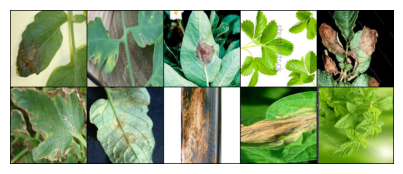

In [ ]:
# Get a batch of training images
images, labels = next(iter(train_loader)) #getting images in the next batch for visualization
print(images.shape)
print(labels.shape)

# Create a grid of images
img_grid = utils.make_grid(images[:10], nrow=5, normalize=True)

# Display the grid
plt.figure(figsize=(5, 2))
plt.imshow(img_grid.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
plt.axis("off")
plt.show()

torch.Size([64, 3, 224, 224])
torch.Size([64])


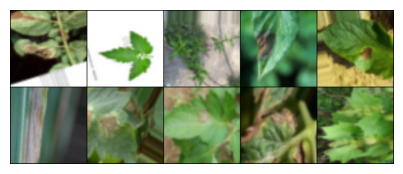

In [ ]:
# Get a batch of augmented training images
images, labels = next(iter(train_aug_loader))
print(images.shape)
print(labels.shape)

# Create a grid of images
img_grid = utils.make_grid(images[:10], nrow=5, normalize=True)

# Display the grid
plt.figure(figsize=(5, 2))
plt.imshow(img_grid.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
plt.axis("off")
plt.show()

#### CNN implementation
Training two CNN models - Low and high complexity and checking for comparison using original dataset and augmented dataset



In [ ]:
#Hyperparameters
num_epochs = 12
num_classes = 2
learning_rate = 0.001

In [ ]:
#First attempt
#Creating convolutional network
class convNet(nn.Module):
  def __init__(self):
    super(convNet, self).__init__() #super() calls the constructor of the nn.Module for proper initialization
    self.layer1 = nn.Sequential(
        nn.Conv2d(3,6,5) #input shape: 3 x 224 224 output = 224 - 5 + 1 = 220 , stride is default 1
        ,nn.ReLU()
        ,nn.MaxPool2d(2,2) #output shape: 6 x 110 x 110
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(6,18,5) #input shape: 6 x 110 x 110 , output = 110 - 5 + 1 = 106
        ,nn.ReLU()
        ,nn.MaxPool2d(2,2) #output shape : 18 x 53 x 53
    )
    self.fc1 = nn.Linear(18*53*53, 10)
    self.fc2 = nn.Linear(10, num_classes)

  def forward (self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = torch.flatten(x, start_dim=1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [ ]:
#Second attempt by increasing model complexity

#Creating convolutional network
class convNet(nn.Module):
    def __init__(self, num_classes=2):
        super(convNet, self).__init__()

        # Input: [3 x 224 x 224]
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),   # -> [64 x 112 x 112]
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)        # -> [64 x 56 x 56]
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),            # -> [64 x 56 x 56]
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)        # -> [64 x 28 x 28]
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # -> [128 x 14 x 14]
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # -> [256 x 7 x 7]
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),           # -> [256 x 7 x 7]
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # -> [256 x 1 x 1]
        self.fc1 = nn.Linear(256, num_classes)       # -> [batch_size, num_classes]

    def forward(self, x):
        x = self.layer1(x)  # -> [64 x 56 x 56]
        x = self.layer2(x)  # -> [64 x 28 x 28]
        x = self.layer3(x)  # -> [128 x 14 x 14]
        x = self.layer4(x)  # -> [256 x 7 x 7]
        x = self.avgpool(x) # -> [256 x 1 x 1]
        x = torch.flatten(x, 1)  # -> [batch_size, 256]
        x = self.fc1(x)     # -> [batch_size, num_classes]
        return x

In [ ]:
model = convNet().to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

#Schedular
step_lr = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) #every 7 epochs learning rate is updates by 0.1

convNet(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tru

In [ ]:
for images, labels in train_aug_loader:
  print("Image type:", type(images))
  print("Label type:", type(labels))
  break

Image type: <class 'torch.Tensor'>
Label type: <class 'torch.Tensor'>


In [ ]:
def eval_model(model, val_loader):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      output = model(images)
      _, predicted = torch.max(output, 1)
      correct += (predicted == labels).sum().item()
      total += labels.size(0)
  return (correct / total)*100

In [ ]:
#K-fold cross validation step
from sklearn.model_selection import RepeatedKFold
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
rkfsplit = rkf.split(train_dataset)

In [ ]:
i=1

training_losses = []
validation_accuracy = []

for train_index, val_index in rkfsplit:

  #Reinitializing model after each fold
  model = convNet().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
  criterion = nn.CrossEntropyLoss()

  print(f"Fold {i} =======================================================")
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_index)
  val_subsampler = torch.utils.data.SubsetRandomSampler(val_index)

  train_aug_loader = DataLoader(train_aug_dataset, batch_size=64, sampler=train_subsampler)
  val_aug_loader = DataLoader(train_aug_dataset, batch_size=64, sampler=val_subsampler)

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  criterion = nn.CrossEntropyLoss()


  ###Training loop###
  for epoch in range(num_epochs):
    correct_train = 0
    total_train = 0
    running_loss = 0

    #training images batch looping
    for images, labels in train_aug_loader:
      model.train() #Calling out Pytorch training mode to ensure proper functioning of layers nn.Batchnorm and nn.Dropout

      optimizer.zero_grad()
      images, labels = images.to(device), labels.to(device)
      output = model(images)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      _, predicted = torch.max(output, 1)
      correct_train += (predicted == labels).sum().item()
      total_train += labels.size(0)

    #Computing average training loss and accuracy after each epoch
    training_accuracy = (correct_train / total_train) * 100
    average_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}")

  final_training_loss = running_loss/ len(train_loader)
  training_losses.append(final_training_loss)

  ###Validation loop###
  model.eval()
  accuracy = eval_model(model, val_aug_loader)
  validation_accuracy.append(accuracy)
  i +=1
  print(f"Validation accuracy: {accuracy:.2f}%, Training accuracy : {training_accuracy:.2f}%")

#Final validation accuracy and training losses averaged across all folds
print(f"Mean Training Loss: {np.mean(training_losses):.4f} ± {np.std(training_losses):.4f}")
print(f"Mean Validation Accuracy: {np.mean(validation_accuracy):.2f}% ± {np.std(validation_accuracy):.4f}")


Fold 1 =======================================================
Epoch 1/12, Loss: 0.4969
Epoch 2/12, Loss: 0.3448
Epoch 3/12, Loss: 0.3578
Epoch 4/12, Loss: 0.3235
Epoch 5/12, Loss: 0.3409
Epoch 6/12, Loss: 0.3227
Epoch 7/12, Loss: 0.3028
Epoch 8/12, Loss: 0.3000
Epoch 9/12, Loss: 0.2460
Epoch 10/12, Loss: 0.2458
Epoch 11/12, Loss: 0.2800
Epoch 12/12, Loss: 0.3812
Validation accuracy: 78.77%, Training accuracy : 82.79%
Fold 2 =======================================================
Epoch 1/12, Loss: 0.4768
Epoch 2/12, Loss: 0.3958
Epoch 3/12, Loss: 0.4032
Epoch 4/12, Loss: 0.3483
Epoch 5/12, Loss: 0.3201
Epoch 6/12, Loss: 0.3545
Epoch 7/12, Loss: 0.3029
Epoch 8/12, Loss: 0.3171
Epoch 9/12, Loss: 0.3982
Epoch 10/12, Loss: 0.3273
Epoch 11/12, Loss: 0.2841
Epoch 12/12, Loss: 0.3294
Validation accuracy: 86.30%, Training accuracy : 86.06%
Fold 3 =======================================================
Epoch 1/12, Loss: 0.4647
Epoch 2/12, Loss: 0.4333
Epoch 3/12, Loss: 0.3674
Epoch 4/12, Loss: 

#### Transfer learning - ResNet18

In [ ]:
model_transfer = models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1") #weights are the pretrained best weights

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 77.1MB/s]


In [ ]:
num_classes = 2   #Healthy/Diseased
n_features = model_transfer.fc.in_features

def model_transfer_fn():
    model = model_transfer
    model.fc = nn.Linear(n_features, num_classes) #Setting the output of last layer to two classes
    return model

model_transfer = model_transfer.to(device)

In [ ]:
#Hyperparameters
lr = 0.001
num_epochs = 10

optimizer = torch.optim.Adam(model_transfer.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [ ]:
#Schedular
step_lr = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) #every 7 epochs learning rate is updates by 0.1

In [ ]:
# Freezing all the layers except the final last layer
for param in model_transfer.parameters():
    param.requires_grad = False  # Gradients are not computed in backward() step to freeze parameters

# Unfreezing the last layer and setting gradient computation to be True
for param in model_transfer.fc.parameters():
    param.requires_grad = True

In [ ]:
#K-fold cross validation step
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
rkfsplit = rkf.split(train_dataset)

In [ ]:
i = 1

training_losses = []
validation_accuracy = []

for train_index, val_index in rkfsplit:

    # Reinitialize model inside each fold
    model_transfer = model_transfer_fn()  # define a function to return a new instance each time
    model_transfer = model_transfer.to(device)

    optimizer = torch.optim.Adam(model_transfer.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    print(f"Fold {i} =======================================================")

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_index)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_index)

    train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_subsampler)
    val_loader = DataLoader(train_dataset, batch_size=64, sampler=val_subsampler)

    ### Training loop ###
    for epoch in range(num_epochs):
        model_transfer.train()
        correct_train = 0
        total_train = 0
        running_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model_transfer(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(output, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        training_accuracy = (correct_train / total_train) * 100
        average_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, Accuracy: {training_accuracy:.2f}%")

    final_training_loss = running_loss / len(train_loader)
    training_losses.append(final_training_loss)

    ### Validation loop ###
    model_transfer.eval()
    accuracy = eval_model(model_transfer, val_loader)
    validation_accuracy.append(accuracy)

    print(f"Fold {i} Validation Accuracy: {accuracy:.2f}%, Final Training Accuracy: {training_accuracy:.2f}%")
    i += 1

# Summary
print(f"\nMean Training Loss: {np.mean(training_losses):.4f} ± {np.std(training_losses):.4f}")
print(f"Mean Validation Accuracy: {np.mean(validation_accuracy):.2f}% ± {np.std(validation_accuracy):.4f}")


Fold 1 =======================================================
Epoch 1/10, Loss: 0.8241, Accuracy: 56.53%
Epoch 2/10, Loss: 0.5691, Accuracy: 73.88%
Epoch 3/10, Loss: 0.4493, Accuracy: 81.44%
Epoch 4/10, Loss: 0.4011, Accuracy: 82.99%
Epoch 5/10, Loss: 0.3520, Accuracy: 88.83%
Epoch 6/10, Loss: 0.3207, Accuracy: 86.25%
Epoch 7/10, Loss: 0.3008, Accuracy: 91.58%
Epoch 8/10, Loss: 0.2648, Accuracy: 89.52%
Epoch 9/10, Loss: 0.2565, Accuracy: 93.13%
Epoch 10/10, Loss: 0.2430, Accuracy: 92.61%
Fold 1 Validation Accuracy: 93.10%, Final Training Accuracy: 92.61%
Fold 2 =======================================================
Epoch 1/10, Loss: 0.6239, Accuracy: 65.64%
Epoch 2/10, Loss: 0.4350, Accuracy: 83.51%
Epoch 3/10, Loss: 0.3483, Accuracy: 89.18%
Epoch 4/10, Loss: 0.2972, Accuracy: 91.07%
Epoch 5/10, Loss: 0.2637, Accuracy: 91.92%
Epoch 6/10, Loss: 0.2688, Accuracy: 91.92%
Epoch 7/10, Loss: 0.2567, Accuracy: 91.58%
Epoch 8/10, Loss: 0.2345, Accuracy: 89.18%
Epoch 9/10, Loss: 0.2091, Accur

#### Statistical comparison and Model Prediction

Since the actual arrays were not recorded due to lack of time, I have done approximate t-tests using average values of accuracy and standard deviation

In [ ]:
import itertools
import math
from scipy.stats import t

models = {
    "Random Forest" :(77.60, 2.47, 15),
    "Low Complexity CNN": (76.52, 4.3509, 15),
    "Low Complexity CNN (with Augmented Dataset)": (76.00, 5.89, 15),
    "High Complexity CNN": (84.74, 4.5064, 15),
    "High Complexity CNN (with Augmented Dataset)": (81.11, 4.5900, 15),
    "Transfer Learning (CNN - ResNet)": (92.26, 1.5755, 15)
}

# Confidence Interval function
def confidence_interval(mean, sd, n, confidence=0.95):
    z = 1.96  # for 95% confidence
    margin = z * (sd / math.sqrt(n))
    return (mean - margin, mean + margin)

# t-test function using mean and standard deviation values
def t_test(mean1, mean2, sd1, sd2, n1, n2):
    numerator = mean1 - mean2
    denominator = math.sqrt((sd1 ** 2 / n1) + (sd2 ** 2 / n2))
    t_stat = numerator / denominator

    # Degrees of freedom approximation
    df = n1 + n2 - 2
    p_value = (1 - t.cdf(abs(t_stat), df)) * 2  # two-tailed
    return t_stat, p_value

#Pairwise comparison of each trained model
for (name1, stats1), (name2, stats2) in itertools.combinations(models.items(), 2):
    mean1, sd1, n1 = stats1
    mean2, sd2, n2 = stats2

    ci1 = confidence_interval(mean1, sd1, n1)
    ci2 = confidence_interval(mean2, sd2, n2)
    t_stat, p_value = t_test(mean1, mean2, sd1, sd2, n1, n2)

    print(f"\nComparison: {name1} vs {name2}")
    print(f" - {name1} CI: {ci1}")
    print(f" - {name2} CI: {ci2}")
    print(f" - t-statistic: {t_stat:.3f}, p-value: {p_value:.4f}")



Comparison: Random Forest vs Low Complexity CNN
 - Random Forest CI: (76.35000753495603, 78.84999246504395)
 - Low Complexity CNN CI: (74.31814080317419, 78.7218591968258)
 - t-statistic: 0.836, p-value: 0.4102

Comparison: Random Forest vs Low Complexity CNN (with Augmented Dataset)
 - Random Forest CI: (76.35000753495603, 78.84999246504395)
 - Low Complexity CNN (with Augmented Dataset) CI: (73.01924873720287, 78.98075126279713)
 - t-statistic: 0.970, p-value: 0.3402

Comparison: Random Forest vs High Complexity CNN
 - Random Forest CI: (76.35000753495603, 78.84999246504395)
 - High Complexity CNN CI: (82.45944694555705, 87.02055305444294)
 - t-statistic: -5.381, p-value: 0.0000

Comparison: Random Forest vs High Complexity CNN (with Augmented Dataset)
 - Random Forest CI: (76.35000753495603, 78.84999246504395)
 - High Complexity CNN (with Augmented Dataset) CI: (78.78713950827864, 83.43286049172136)
 - t-statistic: -2.608, p-value: 0.0144

Comparison: Random Forest vs Transfer Lear

<ipython-input-132-fbaec9afb436>:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(simulated_scores, labels=model_names, patch_artist=True,


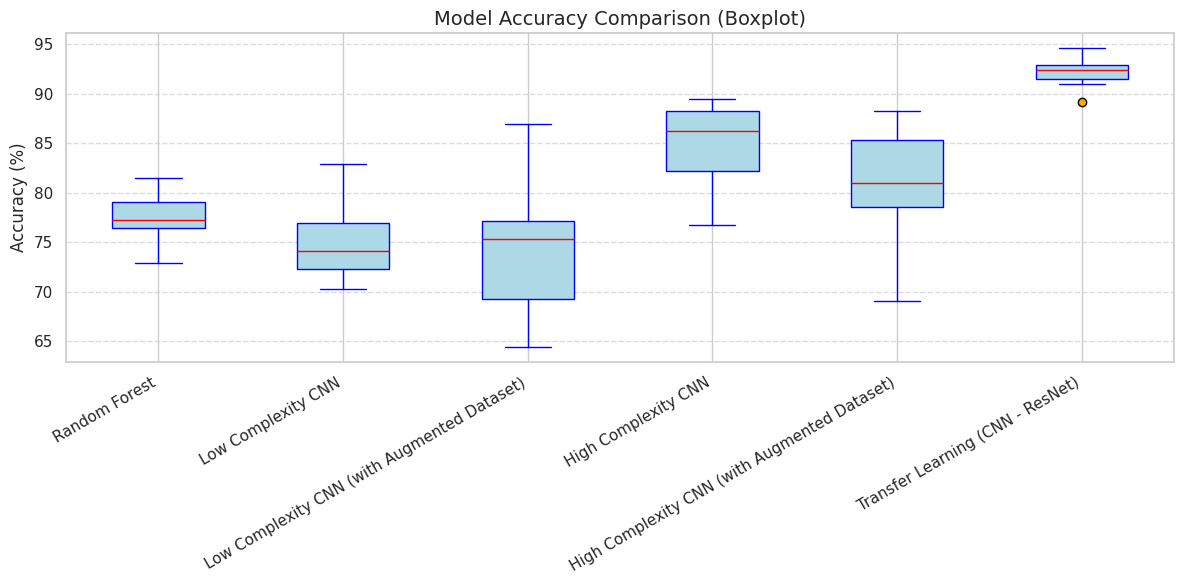

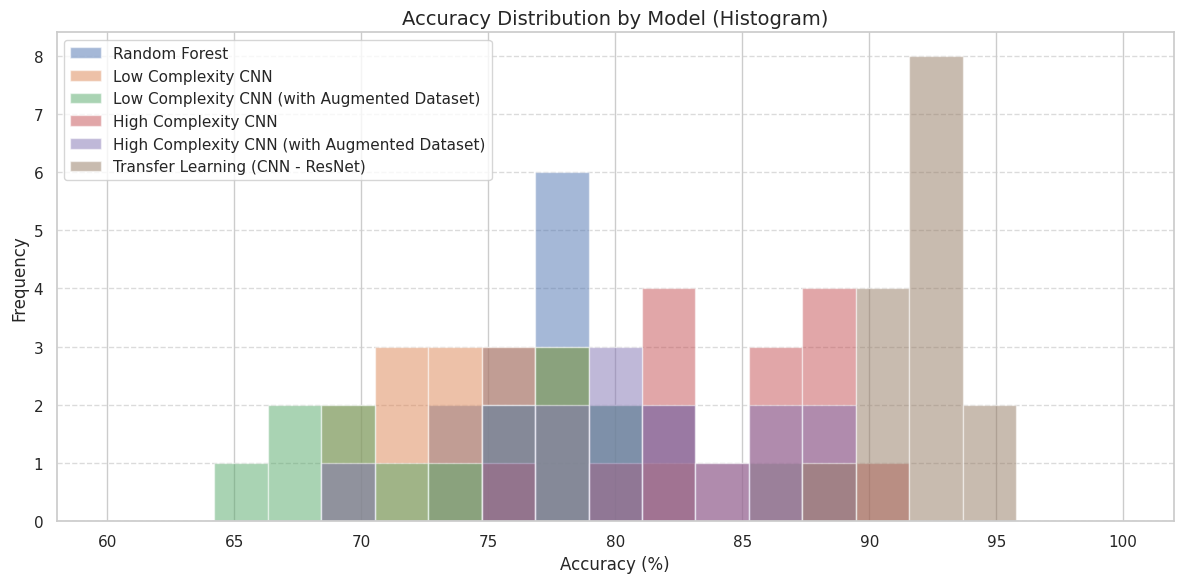

In [ ]:
# Simulate data
np.random.seed(42)
model_names = list(models.keys())
simulated_scores = []

for model_name in model_names:
    mean, std, n = models[model_name]
    scores = np.random.normal(loc=mean, scale=std, size=n)
    simulated_scores.append(scores)

plt.figure(figsize=(12, 6))
plt.boxplot(simulated_scores, labels=model_names, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red'),
            whiskerprops=dict(color='blue'),
            capprops=dict(color='blue'),
            flierprops=dict(markerfacecolor='orange', marker='o', markersize=6))

plt.title('Model Accuracy Comparison (Boxplot)', fontsize=14)
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

# Plot histograms for each model
bins = np.linspace(60, 100, 20)

for scores, name in zip(simulated_scores, model_names):
    plt.hist(scores, bins, alpha=0.5, label=name)

plt.title('Accuracy Distribution by Model (Histogram)', fontsize=14)
plt.xlabel('Accuracy (%)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Based on the comparison, the Transfer Learning model using ResNet emerges as the top performer with a midpoint confidence interval (CI) of 92.3%, significantly outperforming all other models. The High Complexity CNN also shows a strong performance with an 84.7% midpoint CI, indicating that increasing model complexity boosts accuracy. However, when data augmentation was applied to the High Complexity CNN, the performance slightly dipped to 81.1%, though it still outperformed simpler models.

In [ ]:
#Load test data
test_loader = DataLoader(dataset = test_dataset, batch_size = 64, shuffle = False)

In [ ]:
#Prediction of test data with highest performing model
model_transfer.to(device)
model_transfer.eval()

image_names_list = []
predictions_list = []

with torch.no_grad():
  for images, image_names in test_loader:
    images = images.to(device)
    outputs = model_transfer(images)
    _, predicted = torch.max(outputs, 1)
    image_names_list.extend(image_names)
    predictions_list.extend(predicted.cpu().numpy())


df = pd.DataFrame({
    'Image Name': image_names_list,
    'Prediction': predictions_list
})

# Save to Excel
df.to_excel('best_model_predictions.xlsx', index=False)

print("Predictions saved to best_model_predictions.xlsx")

Predictions saved to best_model_predictions.xlsx


#### Segmentation model

In [ ]:
#Hyperparameters

num_epochs = 10
num_classes = 2

In [ ]:
from PIL import Image

class SegmentationDataset (Dataset):
  def __init__ (self, csv_file, image_dir, mask_dir = None, transform = None):
    self.labels = pd.read_csv(csv_file)
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
      img_path = os.path.join(self.image_dir, self.images[idx])
      image = Image.open(img_path).convert("RGB").resize((256,256))
      image_name = self.images[idx]
      if self.transform:
         image = self.transform(image)

      if self.mask_dir:
         mask_path = os.path.join(self.mask_dir, self.images[idx])
         mask = Image.open(mask_path).convert('L')  # ensure grayscale
         if self.transform:
            mask = self.transform(mask)
         if mask.dim() == 2:
            mask = mask.unsqueeze(0)
      else:
         return image, image_name

      return image, mask

In [ ]:
transform = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])

In [ ]:
mask_images_pth = os.path.join(mlds_assignmet_2_ml_dl_path,"Dataset/train/masks")

from torch.utils.data import random_split

dataset_seg = SegmentationDataset(csv_file = train_csv_path, image_dir = train_img_pth, mask_dir = mask_images_pth ,transform=transform)

train_size = int(0.8 * len(dataset_seg))
val_size = len(dataset_seg) - train_size
train_dataset, val_dataset = random_split(dataset_seg, [train_size, val_size])

dataset_seg = SegmentationDataset(csv_file = train_csv_path, image_dir = train_img_pth, mask_dir = mask_images_pth ,transform=transform)
train_loader = DataLoader(train_dataset, batch_size = 8, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 8, shuffle = False)


In [ ]:
#!pip install segmentation-models-pytorch

In [ ]:
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.DeepLabV3Plus(
    encoder_name="resnet34",        # choosing encoder as resnet34
    encoder_weights="imagenet",     # use `imagenet` pretrained weights for encoder initialization
    in_channels=3,                  # model input channels is 3 for RGB images
    classes=1,
    activation = None
).to(device)

In [ ]:
dice_loss = smp.losses.DiceLoss(mode='binary')
bce_loss = nn.BCEWithLogitsLoss()

def criterion(outputs, targets):
    return dice_loss(outputs, targets) + bce_loss(outputs, targets)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [ ]:
def dice_score(preds, targets, smooth=1e-6):
    preds = preds.contiguous().view(-1)
    targets = targets.contiguous().view(-1)

    intersection = (preds * targets).sum()
    dice = (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)
    return dice.item()

In [ ]:
#Model Training
for epoch in range(num_epochs):
  model.train()
  running_loss = 0
  total = 0
  running_dice=0

  for images, masks in train_loader:
    images, masks = images.to(device), masks.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, masks)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    #Training accuracy calculation
    predicted = torch.sigmoid(outputs)
    predicted = (predicted > 0.5).float()
    total += masks.size(0)

    #Training dice score calculation
    dice_score_batch = dice_score(predicted, masks)
    running_dice += dice_score_batch

  average_loss = running_loss / len(train_loader)
  average_train_dice = running_dice / len(train_loader)

  #Validation steps in each epoch

  model.eval()
  val_loss = 0
  val_total = 0
  val_dice = 0

  with torch.no_grad():
    for images, masks in val_loader:
      images, masks = images.to(device), masks.to(device)
      outputs = model(images)
      loss = criterion(outputs, masks)
      val_loss += loss.item()

      predicted = torch.sigmoid(outputs)
      predicted = (predicted > 0.5).float()
      val_total += masks.size(0)
      dice_score_batch = dice_score(predicted.float(), masks.float())
      val_dice += dice_score_batch

  average_val_loss = val_loss / len(val_loader)
  average_val_dice = val_dice / len(val_loader)

  print(f"Epoch {epoch+1}/{num_epochs}")
  print(f"Train Loss: {average_loss:.4f}, Train Dice: {average_train_dice:.2f}")
  print(f"Val Loss:   {average_val_loss:.4f}, Val Dice:   {average_val_dice:.2f}")
  print("-" * 50)

Epoch 1/10
Train Loss: 1.1459, Train Dice: 0.50
Val Loss:   0.9625, Val Dice:   0.60
--------------------------------------------------
Epoch 2/10
Train Loss: 0.7891, Train Dice: 0.67
Val Loss:   0.7325, Val Dice:   0.68
--------------------------------------------------
Epoch 3/10
Train Loss: 0.6235, Train Dice: 0.72
Val Loss:   0.6137, Val Dice:   0.72
--------------------------------------------------
Epoch 4/10
Train Loss: 0.4832, Train Dice: 0.79
Val Loss:   0.5360, Val Dice:   0.74
--------------------------------------------------
Epoch 5/10
Train Loss: 0.4105, Train Dice: 0.81
Val Loss:   0.5124, Val Dice:   0.71
--------------------------------------------------
Epoch 6/10
Train Loss: 0.3764, Train Dice: 0.82
Val Loss:   0.5420, Val Dice:   0.70
--------------------------------------------------
Epoch 7/10
Train Loss: 0.3443, Train Dice: 0.83
Val Loss:   0.4531, Val Dice:   0.74
--------------------------------------------------
Epoch 8/10
Train Loss: 0.3022, Train Dice: 0.85


In [ ]:
test_dataset = SegmentationDataset(csv_file = test_csv_path, image_dir = test_img_pth, transform=transform)
test_loader = DataLoader(test_dataset, batch_size = 8, shuffle = False)

In [ ]:
def mask2rle(img):
    #https://www.kaggle.com/code/paulorzp/rle-functions-run-lenght-encode-decode
    #img: numpy array, 1 - mask, 0 - background
    #Returns run length as string formated
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(256,256)):
    #mask_rle: run-length as string formated (start length)
    #shape: (width,height) of array to return
    #Returns numpy array, 1 - mask, 0 - background
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


In [ ]:
print(next(iter(test_loader)))

In [ ]:
#prediciton
from tqdm import tqdm
output = []

model.eval()
results = []

with torch.no_grad():
    for images, image_names in tqdm(test_loader):
        images = images.to(device)

        outputs = model(images)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        for mask_tensor, image_name in zip(preds, image_names):
            mask = mask_tensor.squeeze().cpu().numpy().astype(np.uint8)

            if mask.sum() == 0:
                rle = ''
            else:
                rle = mask2rle(mask)

            results.append({
                "image_name": image_name,
                "rle_mask": rle
            })

df = pd.DataFrame(results)
df.to_excel('segmentation_submission.xlsx', index=False)


100%|██████████| 49/49 [00:03<00:00, 15.16it/s]
